In [1]:
import numpy as np
import pandas as pd

import numpy as np
from pandas.tseries.offsets import BDay
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
from hurst import compute_Hc, random_walk

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from hurst import compute_Hc, random_walk

In [4]:
def ShannonFast(df):
    df=df[df!=0.0]
    shift_returns = df.shift(1)
    shift_returns2 = df.shift(2)
    shift_returns3 = df.shift(3)
    
    #df['test']  = np.sign(df['returns']).astype('str').dropna() + np.sign(df['shift_returns2']).astype('str').dropna() +  np.sign(df['shift_returns3']).dropna().astype('str')
    
    df =df.dropna(axis=0)
    
    Pattern  = np.sign(df.dropna()).astype('str') + np.sign(shift_returns2.dropna()).astype('str') +  np.sign(shift_returns3.dropna()).astype('str')
    
    Pattern=Pattern.dropna().str.replace('.0','')
    patternList = Pattern.dropna().str.replace('.0','').unique().tolist()
    total = 0.0
    ShannonPatterns = {}
    
    for e in patternList:
        ShannonPatterns[e] = 0

    for pattern in ShannonPatterns.keys():        
        value = (len(np.where(Pattern==pattern)[0]))
        ShannonPatterns[pattern] +=  value
        total += value
        
    
    ProbSum = 0.0
    for pattern in ShannonPatterns.keys():
        p = ShannonPatterns[pattern] / total        
        value = p * np.log2(p)        
        if math.isnan(value):
            continue
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    return Shannon_val

def Shannon(df, patternSize):
    
    chunks = []
    for i in range(0, len(df)):
        chunks.append(df[i:i+patternSize])
    
    chunks = chunks[:-patternSize-1]
    
    
    chunks = [np.array2string(x) for x in chunks.copy()]
    
    
    
    
    chunks_set = list(set(chunks))
    
    
    visited = {}
    total = 0
    for el in chunks_set:
        if (el not in visited):
            f = chunks.count(el)
            visited[el] = f
            total = total + f
    ProbSum = 0.0
    for el in visited:
        p = visited[el]/total
        value = p * np.log2(p)
        #visited[el] = value
        ProbSum = ProbSum + value
    Shannon_val = -ProbSum
    del visited, chunks
    
    
    
    return Shannon_val

def marketMeannes(df):
    
    m = np.median(df) 
    nh = 0
    nl = 0
    
    for i in range(1, len(df)-1):
        Pt = df[i]
        Py = df[i-1]
        
        if (Py > m) & (Py > Pt):
            nl += 1
        elif (Py < m) & (Py < Pt):
            nh += 1
        else:
            None
    return (nl+nh)/(len(df)-1)
        
    
    
def Momersion(df):
    #print(np.where(df == 1)[0])
    #df = df['returns'].copy() * df['returns'].shift(1)
    df = df.copy() * df.shift(1)
    
    df = df.dropna()
    df = np.sign(df)
    pos = len(np.where(df == 1)[0])
    neg = len(np.where(df == -1)[0])
    #zero = len(np.where(df == 0.0)[0])
    if (pos + neg) == 0.0:
        return -1.0
    #print(pos, neg)
    mom = (pos / (pos+neg )) #*100.0
    return mom
# https://pypi.org/project/hurst/
def hurst(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst

def MomersionDouble(df):

    df = df[df!=0.0]
    shift_returns = df.shift(1).fillna(0)
    shift_returns2 = df.shift(2).fillna(0)
    shift_returns3 = df.shift(3).fillna(0)
    Pattern = np.sign(shift_returns * shift_returns2)
    Pattern2= np.sign(shift_returns2 * shift_returns3)
    df = df.dropna()

    pp = len(np.where( (Pattern == 1 ) & (Pattern2 == 1 ) )[0])
    pm = len(np.where( (Pattern == 1 ) & (Pattern2 == -1 ) )[0])
    mp = len(np.where( (Pattern == -1 ) & (Pattern2 == 1 ) )[0])
    mm = len(np.where( (Pattern == -1 ) & (Pattern2 == -1 ) )[0])

    total = (pp+pm-mp-mm)/(df.count()-1.0)
    #threshUp = total>=np.sqrt(len(df))

    return total #(total, len(df), np.sqrt(len(df)))

def proportion(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return pp/mm
    
def proportionPos(df):
    pp = len(np.where( (df >0.0  ) )[0])
    mm = len(np.where( (df < 0.0 ) )[0])
    
    if mm == 0.0 or mm is None:
        mm = 1
    return 100.0 * pp/(pp+mm) 

def autoCorrel(df, lag):
    return pd.Series.autocorr(df, lag)


def hurstF(ts):
    lags = range(2, 20)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # plot on log-log scale
    #plt.plot(np.log(lags), np.log(tau)); plt.show()
    # calculate Hurst as slope of log-log plot
    #print(lags, tau)
    m = np.polyfit(np.log(lags), np.log(tau), 1)

 
    hurst = m[0]*2.0
    #print ('hurst = ',hurst)
    #plt.clf(), plt.close()
    return hurst


def hurstF2(p):
    lags = range(2,100)


    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

def hurstF3(series):
   

    #H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.na).dropna(), kind='price', simplified=True)
    H, c, data = compute_Hc(series.replace([np.inf, -np.inf], np.nan).dropna(), kind='random_walk', simplified=False)
    return H

def hurstF4(series):
   
    
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    return H



In [5]:
def generateRWI2(df):
    MomVal = Momersion(df[['returns']]) 
    MomDouble = MomersionDouble(df['returns'])
 
    h1 =  hurstF(df['price'])
    h2 =  hurstF2(df['price'])
    h3 =  hurstF3(df['price'])

    h4 = hurstF4(df['price'])
   
  
    #df = df.copy().join(autoCorr_features(df[['returns']].copy()), rsuffix='_suka_')
    
    MMIR = marketMeannes(df['returns'])
    
    MMIP = marketMeannes(df['price'])
    ShannonVal = ShannonFast(df['returns'])
    prop = proportionPos(df['returns'])
    correl_1 = autoCorrel(df.returns, 1)
    correl_2 = autoCorrel(df.returns, 2)
    correl_3 = autoCorrel(df.returns, 3)
    correl_4 = autoCorrel(df.returns, 4)
    correl_5 = autoCorrel(df.returns, 5)
    correl_10 = autoCorrel(df.returns, 10)
    correl_20 = autoCorrel(df.returns, 20)
    correl_100 = autoCorrel(df.returns, 100)
    correl_list = [correl_1, correl_2, correl_3, correl_4, correl_5, correl_10, correl_20, correl_100]
    
    var_std = df['returns'].std()
    var_mean = df['returns'].mean()
    var_median = df['returns'].mean()
    
    
    return [MomVal, MomDouble, h1, h2, h3, h4, MMIR, MMIP, ShannonVal, prop, var_std, var_mean, var_median] + correl_list

In [6]:
def generate_features(df):
    df.columns = ['price']
    
    df['returns'] = np.log(df['price']/df['price'].shift(1))
    
    df['ROC_2'] =  np.log(df['price'].copy()).pct_change(2)
    
    df['ROC_3'] = np.log(df['price'].copy()).pct_change(3)
    df['ROC_5'] = np.log(df['price'].copy()).pct_change(5)
    df['ROC_20'] = np.log(df['price'].copy()).pct_change(20)
    df['ROC_50'] = np.log(df['price'].copy()).pct_change(50)
    df['ROC_100'] = np.log(df['price'].copy()).pct_change(100)
    #df['ROC_200'] = np.log(df['price'].copy()).pct_change(200)
    #df['ROC_300'] = np.log(df['price'].copy()).pct_change(300)
    #df['ROC_500'] = np.log(df['price'].copy()).pct_change(500)
    
    
    df['abs_returns'] =  np.abs(np.log(np.abs(df['price'].copy())).pct_change())
    

    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return df

In [7]:
lookup = [1, 1,  2, 2, 3, 4, 5, 10,  20,  50 , 100, 200, 300]

In [8]:
proba = [0.10, 0.20, 0.30, 0.40, 0.45, 0.45, 0.50, 0.50, 0.50, 0.55, 0.55, 0.60, 0.70, 0.80, 0.90]

In [9]:
1500-300

1200

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
[1, 2] + [2, 3]

[1, 2, 2, 3]

In [11]:
df['group']=(df.index.to_series() / 5).astype(int)

NameError: name 'df' is not defined

In [566]:
df.groupby('group').last()

,price,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,ROC_100,abs_returns,shift_returns
group,,,,,,,,,,
0,1.994326,0.001082,0.001201,-0.000667,0.000000,0.000000,0.000000,0.000000,0.001569,0.000979
1,1.997635,-0.000436,-0.000654,0.000012,0.002401,0.000000,0.000000,0.000000,-0.000629,-0.000051
2,2.000000,0.000653,0.001067,0.000372,0.001710,0.000000,0.000000,0.000000,0.000943,-0.000303
3,1.997849,-0.000315,-0.000325,-0.000739,-0.001552,0.000000,0.000000,0.000000,-0.000455,0.000161
4,1.997138,-0.000550,-0.001794,-0.001678,-0.000514,0.002041,0.000000,0.000000,-0.000794,-0.000167
5,1.997803,-0.000429,0.000620,0.001152,0.000481,0.000122,0.000000,0.000000,-0.000620,-0.000566
6,1.996846,0.001009,0.000478,-0.000880,-0.000692,-0.002277,0.000000,0.000000,0.001461,0.000104
7,1.994171,-0.000182,-0.000957,-0.002556,-0.001939,-0.002663,0.000000,0.000000,-0.000263,-0.001041
8,1.988948,-0.000405,-0.001575,-0.000425,-0.003799,-0.005941,0.000000,0.000000,-0.000588,-0.000348


In [14]:
df

,price,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,ROC_100,abs_returns,shift_returns
group,,,,,,,,,,
0,1.771248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051550
1,1.864951,0.051550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090173,-0.042665
2,1.787057,-0.042665,0.015543,0.000000,0.000000,0.000000,0.000000,0.000000,0.068457,-0.015662
3,1.759285,-0.015662,-0.093588,-0.011854,0.000000,0.000000,0.000000,0.000000,0.026978,0.000671
4,1.760466,0.000671,-0.025822,-0.092511,0.000000,0.000000,0.000000,0.000000,0.001187,-0.042981
5,1.686401,-0.042981,-0.074898,-0.099855,-0.085865,0.000000,0.000000,0.000000,0.075995,0.063896
6,1.797673,0.063896,0.036979,0.038211,-0.058953,0.000000,0.000000,0.000000,0.122267,0.029633
7,1.851740,0.029633,0.178970,0.089373,0.061243,0.000000,0.000000,0.000000,0.050526,0.011227
8,1.872647,0.011227,0.069668,0.200453,0.110541,0.000000,0.000000,0.000000,0.018222,-0.024119


In [ ]:
df.shape

In [24]:
results = []
for i in range(0, 101):
    print(i)
    for lk in lookup:
        for prob in proba:
            tmp = random_walk(8000,proba=prob,  min_lookback=lk, max_lookback=lk) #np.random.uniform(0.61, 0.90,1)
            tmp = [e[0] if (type(e)==np.ndarray) else e for e in tmp.copy()]
            df = pd.DataFrame(np.asarray(tmp)+100)
            scaler = MinMaxScaler(feature_range=(0.0, 1.0))
            df_ = scaler.fit_transform(df)
            df_ = pd.DataFrame(df_, columns=df.columns,index=df.index)
            df = (1+df_)
            df['group'] = (df.index.to_series()/5).astype('int')
            df = df.groupby('group').last()
            res = generate_features(df)
            df = df.replace([np.inf, -np.inf],0).fillna(0)

            df['shift_returns'] = df['returns'].shift(-1).dropna()
            df = df[df.shift_returns != 0.0].dropna()
            y = df.iloc[:, [-1]]
            y.shift_returns = np.sign(y.shift_returns)
            X = df.iloc[:, 0:7]
            
            rwi_list = generateRWI2(df)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
            X_train =X[0:1150]
            y_train = y[0:1150]
            X_test = X[1200:]
            y_test = y[1200:]
            
            clf = RandomForestClassifier(n_estimators=100, max_depth=5,
                                         random_state=0)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            rwi_list.append(prob)
            rwi_list.append(lk)
            rwi_list.append(score)
            results.append(rwi_list)
        

        
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [23]:
df.shape

(1599, 10)

In [28]:
df

,price,returns,ROC_2,ROC_3,ROC_5,ROC_20,ROC_50,ROC_100,abs_returns,shift_returns
group,,,,,,,,,,
0,1.000353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000221
1,1.000132,-0.000221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.625486,-0.000013
2,1.000119,-0.000013,-0.663287,0.000000,0.000000,0.000000,0.000000,0.000000,0.100933,-0.000005
3,1.000114,-0.000005,-0.140506,-0.678108,0.000000,0.000000,0.000000,0.000000,0.044016,-0.000064
4,1.000050,-0.000064,-0.581786,-0.623997,0.000000,0.000000,0.000000,0.000000,0.562530,0.000306
5,1.000356,0.000306,2.128503,1.990800,0.007041,0.000000,0.000000,0.000000,6.151355,0.000363
6,1.000719,0.000363,13.450867,5.321820,4.433564,0.000000,0.000000,0.000000,1.020717,0.000342
7,1.001061,0.000342,1.981342,20.320634,7.916597,0.000000,0.000000,0.000000,0.475388,-0.000245
8,1.000816,-0.000245,0.134841,1.293194,6.174264,0.000000,0.000000,0.000000,0.230818,-0.000225


In [29]:
df.columns

Index(['price', 'returns', 'ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'ROC_50',
       'ROC_100', 'abs_returns', 'shift_returns'],
      dtype='object')

In [30]:
cols = ['MomVal', 'MomDouble', 'h1', 'h2', 'h3', 'h4', 'MMIR', 'MMIP', 'ShannonVal', 'prop', 'var_std', 'var_mean', 'var_median',   'correl_1', 'correl_2', 'correl_3', 'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100' ,  'prob', 'lk', 'score']

In [31]:
accuracy_df = pd.DataFrame(results, columns=cols) #.corr(method='spearman')['score'].sort_values()

In [32]:
accuracy_df.to_pickle('accuracy_weekly.pkl')

In [36]:
accuracy_df.corr(method='spearman')['prob'].sort_values()

MMIR         -0.780355
var_std      -0.724229
MMIP         -0.441151
ShannonVal   -0.353025
lk            0.000000
prop          0.011816
var_mean      0.015422
var_median    0.015422
score         0.113643
correl_100    0.186005
correl_20     0.233339
correl_10     0.247834
correl_5      0.335154
correl_4      0.447872
correl_3      0.483043
h4            0.500987
h2            0.544730
correl_2      0.575952
h3            0.667149
h1            0.729925
MomDouble     0.869637
MomVal        0.869703
correl_1      0.876441
prob          1.000000
Name: prob, dtype: float64

In [87]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm_df = pd.DataFrame(scaler.fit_transform(accuracy_df), index=accuracy_df.index, columns=accuracy_df.columns)
norm_df['prob'] = accuracy_df['prob']
#


In [88]:
#norm_df.drop(columns=['ShannonVal', 'prob', 'lk'], inplace=True)

In [89]:
cols = ['prob' ,'MomVal', 'MomDouble', 'h1', 'h2', 'h3', 'h4', 'MMIR', 'MMIP', 'ShannonVal', 'prop',   'correl_1', 'correl_2', 'correl_3', 'correl_4', 'correl_5', 'correl_10', 'correl_20', 'correl_100' ,    'score' ]

In [73]:
cols = [ 'prob', 'h4',  'correl_1',  'score']

In [90]:
norm_df = norm_df[cols]

In [91]:
X = norm_df.drop(columns=['prob' ,'score'])
y = norm_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = Lasso(alpha=0.0001).fit(X_train, y_train)

In [92]:
reg.score(X_test, y_test)

0.6509358035496182

In [93]:
cols[:-1]

['prob',
 'MomVal',
 'MomDouble',
 'h1',
 'h2',
 'h3',
 'h4',
 'MMIR',
 'MMIP',
 'ShannonVal',
 'prop',
 'correl_1',
 'correl_2',
 'correl_3',
 'correl_4',
 'correl_5',
 'correl_10',
 'correl_20',
 'correl_100']

In [94]:
pd.DataFrame(reg.coef_, index=X_test.columns).sort_values(by=0)

,0
h1,-0.508742
correl_1,-0.433816
MMIR,-0.186831
ShannonVal,-0.163884
h4,-0.067142
correl_20,-0.049861
correl_100,-0.045116
h2,-0.043213
correl_10,-0.023422
correl_4,0.009329


In [25]:
X_train.columns

Index(['price', 'returns', 'ROC_2', 'ROC_3', 'ROC_5', 'ROC_20', 'ROC_50'], dtype='object')

In [95]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(max_depth=10)
reg_tree.fit(X_train, y_train)
y_pred = reg_tree.predict(X_test)

reg_tree.score(X_test, y_test)


0.6087505831136786

In [557]:
import pickle

In [96]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(max_depth=10)
reg_tree.fit(X, y)
y_pred = reg_tree.predict(X)

reg_tree.score(X, y)


0.8575515340461018

In [97]:
filename = 'probability_prediction.sav'
pickle.dump(reg_tree, open(filename, 'wb'))

NameError: name 'pickle' is not defined

In [98]:
y_pred = reg_tree.predict(X_test)

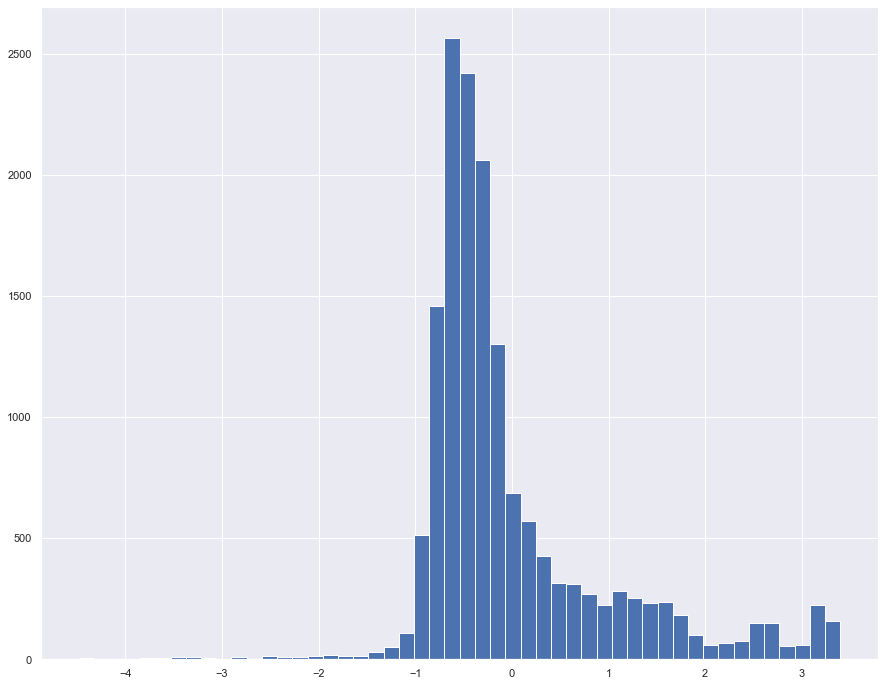

In [99]:
y_train.hist(bins=50, figsize=(15,12))

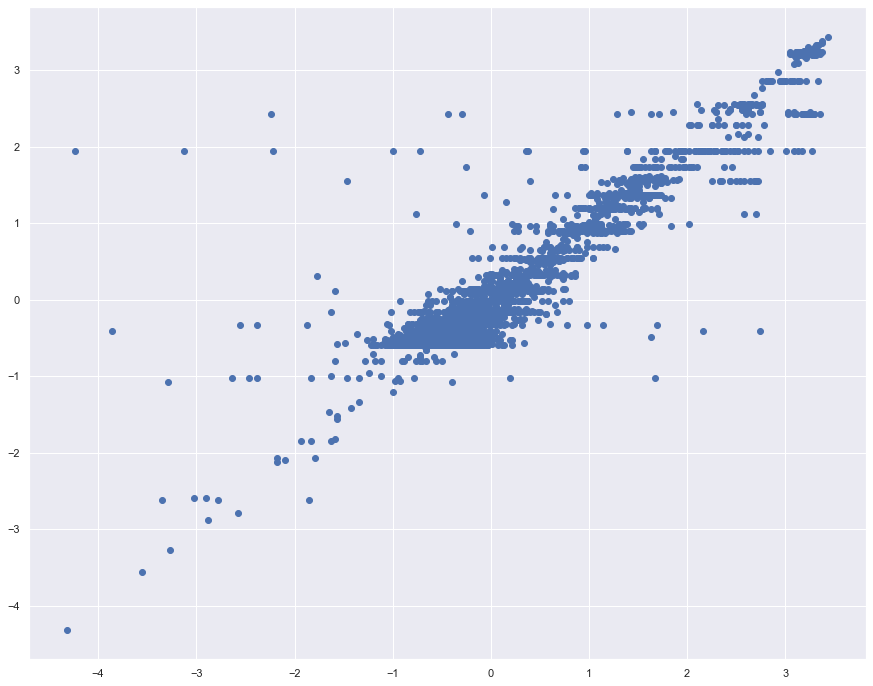

In [100]:
plt.figure(figsize=(15,12))
plt.plot(y_test, y_pred, 'o')


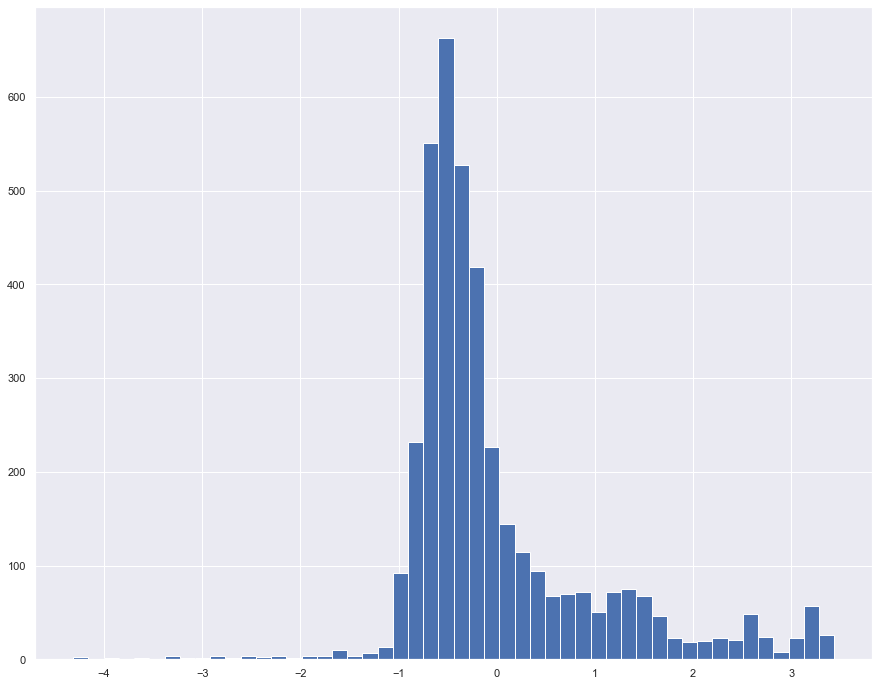

In [101]:
y_test.hist(bins=50, figsize=(15,12))

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 5.000e+00, 1.300e+01, 1.300e+01, 7.570e+02,
        1.153e+03, 3.880e+02, 3.160e+02, 1.710e+02, 1.690e+02, 9.200e+01,
        3.600e+01, 6.500e+01, 4.000e+01, 9.900e+01, 5.000e+01, 6.900e+01,
        1.050e+02, 6.200e+01, 1.800e+01, 3.500e+01, 6.600e+01, 5.000e+00,
        1.300e+01, 5.000e+01, 3.700e+01, 2.000e+00, 1.800e+01, 3.000e+00,
        5.300e+01, 1.300e+01]),
 array([-4.31380408, -4.15877671, -4.00374934, -3.84872197, -3.6936946 ,
        -3.53866723, -3.38363986, -3.22861249, -3.07358512, -2.91855775,
        -2.76353038, -2.60850301, -2.45347564, -2.29844827, -2.1434209 ,
        -1.98839353, -1.83336616, -1.67833879, -1.52331142, -1.36828405,
        -1.21325668, -1.05822931, -0.90320194, -0.74817457, -0.5931472 ,
        -0.

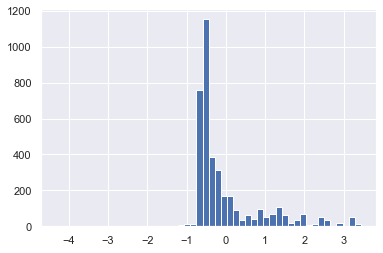

In [102]:
plt.hist(y_pred, bins=50)

In [103]:
pd.DataFrame(reg_tree.feature_importances_, index=X_test.columns).sort_values(by=0)

,0
correl_4,0.003311
MomVal,0.003736
correl_100,0.006656
correl_1,0.008117
correl_2,0.008366
MMIP,0.008493
correl_3,0.009282
correl_5,0.009750
MMIR,0.010359
correl_20,0.010372


In [104]:
analysis_df = accuracy_df.copy()

In [105]:
cond = (analysis_df.score<0.49)
cond = (analysis_df.h4<0.51) & ((analysis_df.h4>0.49) )


In [106]:
analysis_df.corr()['prob'].round(2).sort_values()

MMIR         -0.73
var_std      -0.64
ShannonVal   -0.53
MMIP         -0.47
lk           -0.00
var_mean      0.01
var_median    0.01
prop          0.01
correl_20     0.24
correl_100    0.27
correl_10     0.28
score         0.32
correl_5      0.35
correl_4      0.46
correl_3      0.52
h2            0.54
h4            0.56
correl_2      0.59
h3            0.63
h1            0.66
correl_1      0.79
MomDouble     0.82
MomVal        0.82
prob          1.00
Name: prob, dtype: float64

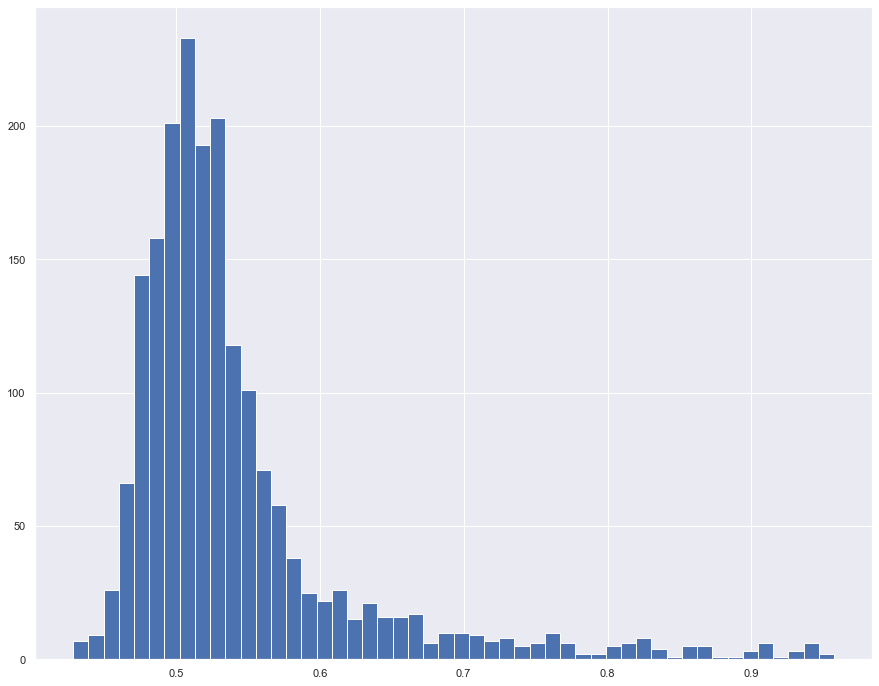

In [107]:
analysis_df[cond]['score'].hist(bins=50, figsize=(15,12))

In [166]:
analysis_df[cond]['score'].std()*3 - analysis_df[cond]['score'].mean()

-0.41339810814538014

In [165]:
np.sqrt(100)

10.0